<a href="https://colab.research.google.com/github/JulianoMata/dio-treinamento-de-redes-neurais/blob/main/C%C3%B3pia_de_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning / fine-tuning

Este tutorial o guiará pelo processo de uso do aprendizado de transferência para aprender um classificador de imagem preciso a partir de um número relativamente pequeno de amostras de treinamento. De um modo geral, a aprendizagem de transferência refere-se ao processo de alavancar o conhecimento aprendido em um modelo para o treinamento de outro modelo.
Mais especificamente, o processo envolve pegar uma rede neural existente que foi previamente treinada para um bom desempenho em um conjunto de dados maior e usá-la como base para um novo modelo que aproveita a precisão da rede anterior para uma nova tarefa. Este método tornou-se popular nos últimos anos para melhorar o desempenho de uma rede neural treinada em um pequeno conjunto de dados; a intuição é que o novo conjunto de dados pode ser muito pequeno para ser treinado para um bom desempenho por si só, mas sabemos que a maioria das redes neurais treinadas para aprender recursos de imagem geralmente aprendem recursos semelhantes de qualquer maneira, especialmente nas camadas iniciais, onde são mais genéricos (detectores de borda, bolhas, e assim por diante).


A aprendizagem por transferência foi amplamente possibilitada pelo código aberto de modelos de última geração; para os modelos de melhor desempenho em tarefas de classificação de imagens  (como do [ILSVRC](http://www.image-net.org/challenges/LSVRC/)), é prática comum agora não apenas publicar a arquitetura, mas também liberar os pesos treinados do modelo. Isso permite que amadores usem esses classificadores de imagem para aumentar o desempenho de seus próprios modelos específicos de tarefas.

#### Feature extraction vs. fine-tuning

Em um extremo, o aprendizado de transferência pode envolver pegar a rede pré-treinada e congelar os pesos e usar uma de suas camadas ocultas (geralmente a última) como um extrator de recursos, usando esses recursos como entrada para uma rede neural menor.
No outro extremo, começamos com a rede pré-treinada, mas permitimos que alguns dos pesos (geralmente a última camada ou as últimas camadas) sejam modificados. Outro nome para este procedimento é chamado de "ajuste fino" porque estamos ajustando levemente os pesos da rede pré-treinada para a nova tarefa. Normalmente treinamos essa rede com uma taxa de aprendizado menor, pois esperamos que os recursos já sejam relativamente bons e não precisem ser muito alterados.


Às vezes, fazemos algo intermediário: congelar apenas as camadas iniciais/genéricas, mas ajustar as camadas posteriores. Qual estratégia é a melhor depende do tamanho do seu conjunto de dados, do número de classes e do quanto ele se assemelha ao conjunto de dados no qual o modelo anterior foi treinado (e, portanto, se ele pode se beneficiar dos mesmos extratores de recursos aprendidos). Uma discussão mais detalhada de como criar estratégias pode ser encontrada em [[1]](http://cs231n.github.io/transfer-learning/) [[2]](http://sebastianruder.com/transfer-learning/).

## Procedure

Neste guia, passaremos pelo processo de carregamento de um classificador de imagens de 1000 classes de última geração, [VGG16](https://arxiv.org/pdf/1409.1556.pdf) que venceu o [ImageNet challenge em 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), e o uso como um extrator de recursos fixos para treinar um classificador personalizado menor em nosso suas próprias imagens, embora com muito poucas alterações de código, você também pode tentar ajustar.

Primeiro vamos carregar o VGG16 e remover sua camada final, a camada de classificação softmax de 1000 classes específica para ImageNet, e substituí-la por uma nova camada de classificação para as classes sobre as quais estamos treinando. Em seguida, congelaremos todos os pesos na rede, exceto os novos que se conectam à nova camada de classificação, e treinaremos a nova camada de classificação sobre nosso novo conjunto de dados.

Também compararemos esse método com o treinamento de uma pequena rede neural do zero no novo conjunto de dados e, como veremos, melhorará drasticamente nossa precisão. Faremos essa parte primeiro.

Como nosso sujeito de teste, usaremos um conjunto de dados composto por cerca de 5960 imagens pertencentes a 97 classes e treinaremos um classificador de imagens com cerca de 80% de precisão. Vale a pena notar que essa estratégia se adapta bem a conjuntos de imagens em que você pode ter apenas algumas centenas ou menos imagens. Seu desempenho será menor a partir de um pequeno número de amostras (dependendo das classes) como de costume, mas ainda impressionante considerando as restrições usuais.


In [33]:
%matplotlib inline

import os

#if using Theano with GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model

### Getting a dataset

O primeiro passo será carregar nossos dados. Como nosso exemplo, usaremos o conjunto de dados [CalTech-101](http://www.vision.caltech.edu/datasets/), que contém cerca de 9.000 imagens rotuladas pertencentes a 101 categorias de objetos. No entanto, excluiremos 6 das categorias que tiverem mais imagens. Isso é para manter a distribuição de classes bastante equilibrada (em torno de 50-100) e restrita a um número menor de imagens, em torno de 5960.

Se você deseja usar seu próprio conjunto de dados, ele deve ser organizado da mesma forma `101_ObjectCategories` com todas as imagens organizadas em subpastas, uma para cada classe. Nesse caso, a célula a seguir deve carregar seu conjunto de dados personalizado corretamente apenas substituindo `root` por sua pasta. Se você tiver uma estrutura alternativa, você só precisa ter certeza de carregar a lista `data` onde cada elemento é um dict onde `x` estão os dados (um array numpy 1-d) e `y` é o rótulo (um inteiro). Use a função auxiliar `get_image(path)`para carregar a imagem corretamente no array e observe também que as imagens estão sendo redimensionadas para 224x224. Isso é necessário porque a entrada para VGG16 é uma imagem RGB de 224x224. Você não precisa redimensioná-los em seu disco rígido, pois isso está sendo feito no código abaixo.



In [34]:
!echo "Downloading 101_Object_Categories for image notebooks"
!curl -L -o 101_ObjectCategories.tar.gz --progress-bar https://github.com/JulianoMata/dio-treinamento-de-redes-neurais/blob/main/Dados/101_ObjectCategories.tar.gz?raw=true
!tar -xzf 101_ObjectCategories.tar.gz
!rm 101_ObjectCategories.tar.gz
!ls


######################################################################## 100.0%
101_ObjectCategories  sample_data


In [35]:
dados = ('/content/101_ObjectCategories')
train_split, val_split = 0.7, 0.15

categories = [x[0] for x in os.walk(dados) if x[0]][1:]
categories = [c for c in categories]

print(categories)

['/content/101_ObjectCategories/PetImages', '/content/101_ObjectCategories/PetImages/Cat', '/content/101_ObjectCategories/PetImages/Dog']


Esta função é útil para pré-processar os dados em uma imagem e vetor de entrada.

In [36]:
# helper function to load image and return it and input vector
def get_image(path):
    img = keras.utils.load_img(path, target_size=(224, 224))
    # img = image.load_img(path, target_size=(224, 224)) --> 'erro na execução'
    x = keras.utils.img_to_array(img)
    # x = image.img_to_array(img) --> 'erro na excecução'
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

Carregue todas as imagens da pasta raiz.

In [37]:
data = []
for c, category in enumerate(categories):
    images = [os.path.join(dp, f) for dp, dn, filenames 
              in os.walk(category) for f in filenames 
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    for img_path in images:
        img, x = get_image(img_path)
        data.append({'x':np.array(x[0]), 'y':c})

# count the number of classes
num_classes = len(categories)
print(f'Temos \033[1;32m{num_classes}\033[m classes')

Temos 3 classes


Randomize a ordem dos dados.

In [38]:
random.shuffle(data)

Criar treinamento / validação / divisão de teste (70%, 15%, 15%)

In [39]:
idx_val = int(train_split * len(data))
idx_test = int((train_split + val_split) * len(data))
train = data[:idx_val]
val = data[idx_val:idx_test]
test = data[idx_test:]

Dados separados para rótulos.

In [40]:
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[1, 2, 0, 0, 2, 0, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 2, 0, 0, 0, 2, 1, 2, 1, 0, 2, 0, 1, 2, 1, 0, 1, 0, 2, 1, 2, 1, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 2, 2, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 2, 1, 1, 0, 1, 0, 2, 1, 2, 2, 1, 1, 1, 0, 0, 2, 2, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 2, 0, 2, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 2, 0, 0, 0, 2, 0, 0, 1, 2, 1, 0, 1, 0, 0, 0, 0, 1, 0, 2, 2, 2, 1, 0, 0, 2, 0, 1, 2, 0, 0, 2, 2, 2, 2, 0, 2, 1, 1, 0, 0, 1, 2, 1, 2, 1, 0, 0, 0, 0, 1, 0, 2, 0, 1, 2, 0, 2, 1, 0, 0, 2, 1, 2, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 1, 0, 0, 1, 1, 2, 0, 0, 1, 0, 0, 1, 2, 0, 1, 1, 1, 0, 2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 0, 0, 1, 2, 1, 2, 1, 2, 2, 0, 0, 0, 2, 0, 2, 1, 0, 0, 2, 0, 0, 2, 0, 2, 2]


Pré-processe os dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e 1.

In [41]:
# normalize data
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# convert labels to one-hot vectors
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(241, 3)


Vamos fazer um resumo do que temos.

In [42]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 1604 images from 3 categories
train / validation / test split: 1122, 241, 241
training data shape:  (1122, 224, 224, 3)
training labels shape:  (1122, 3)


Se tudo funcionou corretamente, você deve ter carregado um monte de imagens e dividido em três conjuntos: `train`, `val`, e `test`. A forma dos dados de treinamento deve ser (`n`, 224, 224, 3) onde `n` né o tamanho do seu conjunto de treinamento, e os rótulos devem ser (`n`, `c`) onde `c` cé o número de classes (3 no caso de `101_ObjectCategories`). 

Observe que dividimos todos os dados em três subconjuntos – um conjunto de treinamento -- `train`, um conjunto de validação -- `val`, e um conjunto de teste -- `test`. A razão para isso é avaliar adequadamente a precisão do nosso classificador. Durante o treinamento, o otimizador usa o conjunto de validação para avaliar seu desempenho interno, a fim de determinar o gradiente sem overfitting ao conjunto de treinamento. O conjunto `test` é sempre retirado do algoritmo de treinamento e é usado apenas no final para avaliar a precisão final do nosso modelo.
Vejamos rapidamente algumas imagens de amostra do nosso conjunto de dados.


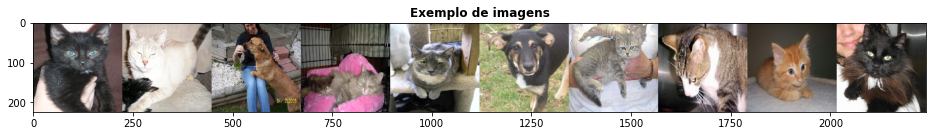

In [43]:
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk('/content/101_ObjectCategories') for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
idx = [int(len(images) * random.random()) for i in range(10)]
imgs = [keras.utils.load_img(images[i], target_size=(224, 224)) for i in idx]
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
plt.figure(figsize=(16,4))
plt.title('Exemplo de imagens', fontweight ="bold")                                    
plt.imshow(concat_image)
plt.show()

### First training a neural net from scratch

Antes de fazer o aprendizado de transferência, vamos primeiro construir uma rede neural do zero para fazer a classificação em nosso conjunto de dados. Isso nos dará uma linha de base para comparar com nossa rede aprendida por transferência mais tarde.

A rede que construiremos contém 4 camadas alternadas convolucional e de pool máximo, seguidas por um [dropout](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) após cada par `conv/pooling`. Após a última camada de `pooling`, anexaremos uma camada totalmente conectada com 128 neurônios, outra camada `dropout` e, finalmente, uma camada de classificação `softmax` para nossas classes.

Nossa função de perda será, como de costume, perda categórica de entropia cruzada, e nosso algoritmo de aprendizado será  [AdaDelta](https://arxiv.org/abs/1212.5701). Várias coisas sobre esta rede podem ser alteradas para obter melhor desempenho, talvez usar uma rede maior ou um otimizador diferente ajude, mas para os propósitos deste notebook, o objetivo é apenas obter uma compreensão de uma linha de base aproximada para fins de comparação e então não é necessário gastar muito tempo tentando otimizar esta rede.

Ao compilar a rede, vamos executar `model.summary()` para obter um instantâneo de suas camadas.

In [44]:
# build the network
model = Sequential()
print("Input dimensions: ",x_train.shape[1:])

model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation('softmax'))

model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 activation_12 (Activation)  (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_13 (Activation)  (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                 

Criamos uma rede de tamanho médio com aproximadamente 1,2 milhão de pesos e vieses (os parâmetros). A maioria deles está levando para uma camada totalmente conectada pré-softmax "dense_5".
Agora podemos ir em frente e treinar nosso modelo para 6 épocas com um tamanho de lote de 32. Também registraremos seu histórico para que possamos plotar a perda ao longo do tempo mais tarde.


In [45]:
# compile the model to use categorical cross-entropy loss function and adadelta optimizer
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size = 128,
                    epochs = 30,
                    validation_data=(x_val, y_val))


Epoch 1/30
9/9 [==============================] - 2s 201ms/step - loss: 1.0545 - accuracy: 0.4831 - val_loss: 1.0330 - val_accuracy: 0.5311
Epoch 2/30
9/9 [==============================] - 2s 171ms/step - loss: 1.0411 - accuracy: 0.5036 - val_loss: 1.0510 - val_accuracy: 0.5311
Epoch 3/30
9/9 [==============================] - 2s 172ms/step - loss: 1.0444 - accuracy: 0.5036 - val_loss: 1.0310 - val_accuracy: 0.5311
Epoch 4/30
9/9 [==============================] - 2s 173ms/step - loss: 1.0397 - accuracy: 0.5036 - val_loss: 1.0391 - val_accuracy: 0.5311
Epoch 5/30
9/9 [==============================] - 2s 172ms/step - loss: 1.0313 - accuracy: 0.5036 - val_loss: 1.0255 - val_accuracy: 0.5311
Epoch 6/30
9/9 [==============================] - 2s 172ms/step - loss: 1.0298 - accuracy: 0.5027 - val_loss: 1.0317 - val_accuracy: 0.5311
Epoch 7/30
9/9 [==============================] - 2s 172ms/step - loss: 1.0241 - accuracy: 0.5045 - val_loss: 1.0250 - val_accuracy: 0.5311
Epoch 8/30
9/9 [====

Vamos plotar a perda de validação e a precisão da validação ao longo do tempo.

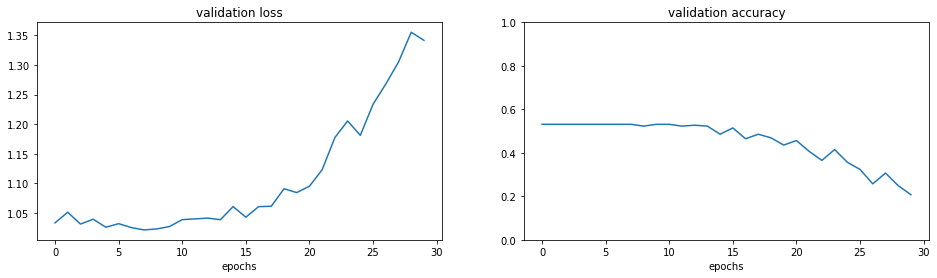

In [46]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que a perda de validação começa a aumentar após cerca de 16 épocas, embora a precisão da validação permaneça aproximadamente entre 40% e 50%. Isso sugere que nosso modelo começa a se ajustar por volta dessa época, e o melhor desempenho teria sido alcançado se tivéssemos parado cedo nessa época. No entanto, nossa precisão provavelmente não teria sido superior a 50%, e provavelmente inferior.
Também podemos obter uma avaliação final executando nosso modelo no conjunto de treinamento. Fazendo isso, obtemos os seguintes resultados:


In [47]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 1.3397724628448486
Test accuracy: 0.1618257313966751


Por fim, vemos que atingimos uma precisão (top-1) de cerca de 49%. Isso não é tão ruim para 6000 imagens, considerando que se usássemos uma estratégia ingênua de fazer suposições aleatórias, teríamos obtido apenas cerca de 1% de precisão.

## Transfer learning by starting with existing network

Now we can move on to the main strategy for training an image classifier on our small dataset: by starting with a larger and already trained network.

Agora podemos passar para a estratégia principal para treinar um classificador de imagens em nosso pequeno conjunto de dados: começando com uma rede maior e já treinada.
Para começar, vamos carregar o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online. Se esta for sua primeira vez carregando o VGG16, você precisará esperar um pouco para que os pesos sejam baixados da web. Uma vez que a rede é carregada, podemos inspecionar novamente as camadas com o método
`summary()`.

In [48]:
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Observe que o VGG16 é muito maior que a rede que construímos anteriormente. Ele contém 13 camadas convolucionais e duas camadas totalmente conectadas no final, e tem mais de 138 milhões de parâmetros, cerca de 100 vezes mais parâmetros do que a rede que fizemos acima. Como nossa primeira rede, a maioria dos parâmetros é armazenada nas conexões que levam à primeira camada totalmente conectada.

O VGG16 foi feito para resolver o ImageNet e atinge uma [taxa de erro top 5 de 8,8%](https://github.com/jcjohnson/cnn-benchmarks), o que significa que 91,2% das amostras de teste foram classificadas corretamente dentro das 5 principais previsões para cada imagem. A precisão top 1 - equivalente à métrica de precisão que estamos usando (que a previsão principal está correta) - é de 73%. Isso é especialmente impressionante, pois não há apenas 97, mas 1.000 classes, o que significa que suposições aleatórias nos dariam apenas 0,1% de precisão.

Para usar essa rede para nossa tarefa, "removemos" a camada de classificação final, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e a substituímos por uma nova camada softmax para nosso conjunto de dados, que contém 97 neurônios no caso do conjunto de dados 101_ObjectCategories.

Em termos de implementação, é mais fácil simplesmente criar uma cópia do VGG de sua camada de entrada até a penúltima camada e trabalhar com isso, em vez de modificar o objeto VGG diretamente. Então, tecnicamente, nunca "removemos" nada, apenas contornamos/ignoramos. Isso pode ser feito da seguinte maneira, usando o `Model` classe keras para inicializar um novo modelo cuja camada de entrada é a mesma que VGG, mas cuja camada de saída é nossa nova camada softmax, chamada  `new_classification_layer`.

Nota: embora pareça que estamos duplicando essa grande rede, internamente o Keras está apenas copiando todas as camadas por referência e, portanto, não precisamos nos preocupar em sobrecarregar a memória.

In [49]:
# make a reference to VGG's input layer
inp = vgg.input

# make a new softmax layer with num_classes neurons
new_classification_layer = Dense(num_classes, activation='softmax')

# connect our new layer to the second to last layer in VGG, and make a reference to it
out = new_classification_layer(vgg.layers[-2].output)

# create a new network between inp and out
model_new = Model(inp, out)


Vamos treinar novamente esta rede, `model_new` newno novo conjunto de dados e rótulos. Mas primeiro, precisamos congelar os pesos e desvios em todas as camadas da rede, exceto nossa nova no final, com a expectativa de que os recursos aprendidos no VGG ainda sejam bastante relevantes para a nova tarefa de classificação de imagens. Não é o ideal, mas provavelmente melhor do que podemos treinar em nosso conjunto de dados limitado. 

Ao definir o `trainable` trainablesinalizador em cada camada como false (exceto nossa nova camada de classificação), garantimos que todos os pesos e vieses nessas camadas permaneçam fixos e simplesmente treinamos os pesos em uma camada no final. Em alguns casos, é desejável não congelar todas as camadas de pré-classificação. Se o seu conjunto de dados tiver amostras suficientes e não se assemelhar muito ao ImageNet, pode ser vantajoso ajustar algumas das camadas VGG junto com o novo classificador, ou possivelmente até mesmo todas elas. Para fazer isso, você pode alterar o código abaixo para tornar mais das camadas treináveis.

No caso do CalTech-101, faremos apenas a extração de recursos, temendo que o ajuste fino demais com esse conjunto de dados possa ser excessivo. Mas talvez estejamos errados? Um bom exercício seria experimentar ambos e comparar os resultados.

Então vamos em frente e congelamos as camadas, e compilamos o novo modelo com exatamente o mesmo otimizador e função de perda que em nossa primeira rede, para uma comparação justa. Em seguida, corremos 
 `summary` novamente para observar a arquitetura da rede.

In [50]:
# make all layers untrainable by freezing weights (except for last layer)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# ensure the last layer is trainable/not frozen
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Observando o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto que a última camada, anteriormente um softmax de 1.000 neurônios, foi substituída por um novo softmax de 97 neurônios. Além disso, ainda temos cerca de 134 milhões de pesos, mas agora a grande maioria deles são "parâmetros não treináveis" porque congelamos as camadas em que estão contidos. Agora temos apenas 397.000 parâmetros treináveis, o que na verdade é apenas um quarto dos número de parâmetros necessários para treinar o primeiro modelo.

Como antes, vamos em frente e treinamos o novo modelo, usando os mesmos hiperparâmetros (tamanho do lote e número de épocas) de antes, juntamente com o mesmo algoritmo de otimização. Também acompanhamos sua história à medida que avançamos.


In [51]:
history2 = model_new.fit(x_train, y_train, 
                         batch_size = 128, 
                         epochs = 30, 
                         validation_data=(x_val, y_val))


Epoch 1/30
9/9 [==============================] - 8s 886ms/step - loss: 1.2828 - accuracy: 0.3779 - val_loss: 1.0375 - val_accuracy: 0.5187
Epoch 2/30
9/9 [==============================] - 8s 855ms/step - loss: 1.0255 - accuracy: 0.4955 - val_loss: 1.0053 - val_accuracy: 0.4564
Epoch 3/30
9/9 [==============================] - 8s 871ms/step - loss: 0.9577 - accuracy: 0.5098 - val_loss: 0.9976 - val_accuracy: 0.4191
Epoch 4/30
9/9 [==============================] - 8s 888ms/step - loss: 0.9277 - accuracy: 0.5232 - val_loss: 0.9578 - val_accuracy: 0.4440
Epoch 5/30
9/9 [==============================] - 8s 897ms/step - loss: 0.9174 - accuracy: 0.4884 - val_loss: 0.9239 - val_accuracy: 0.4481
Epoch 6/30
9/9 [==============================] - 8s 898ms/step - loss: 0.8845 - accuracy: 0.5134 - val_loss: 0.9208 - val_accuracy: 0.4772
Epoch 7/30
9/9 [==============================] - 8s 894ms/step - loss: 0.8773 - accuracy: 0.5187 - val_loss: 0.9668 - val_accuracy: 0.4357
Epoch 8/30
9/9 [====

Nossa precisão de validação paira perto de 80% no final, o que é mais de 30% de melhoria na rede original treinada do zero (o que significa que fazemos a previsão errada em 20% das amostras, em vez de 50%).

Vale a pena notar também que esta rede realmente treina um pouco mais rápido que a rede original, apesar de ter mais de 100 vezes mais parâmetros! Isso ocorre porque o congelamento dos pesos nega a necessidade de retropropagação por todas essas camadas, economizando tempo de execução.

Vamos plotar a perda de validação e precisão novamente, desta vez comparando o modelo original treinado do zero (em azul) e o novo modelo aprendido por transferência em laranja.


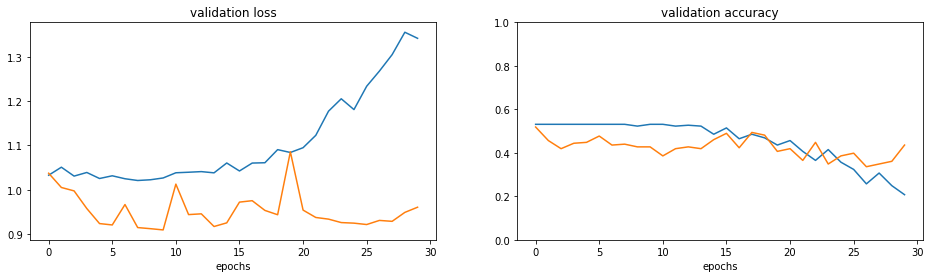

In [52]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.plot(history2.history["val_loss"])
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.plot(history2.history["val_accuracy"])
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Observe que, enquanto o modelo original começou a se ajustar em torno da época 16, o novo modelo continuou a diminuir lentamente sua perda ao longo do tempo e provavelmente melhoraria ligeiramente sua precisão com mais iterações. O novo modelo chegou a aproximadamente 80% de precisão top-1 (no conjunto de validação) e continuou a melhorar lentamente por 30 épocas.

É possível que pudéssemos ter melhorado o modelo original com melhor regularização ou mais abandono, mas certamente não teríamos compensado a melhoria >30% na precisão.
Novamente, fazemos uma validação final no conjunto de teste.


In [53]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.9826393127441406
Test accuracy: 0.39419087767601013


Para prever uma nova imagem, basta executar o código a seguir para obter as probabilidades de cada classe.

In [54]:
img, x = get_image('/content/101_ObjectCategories/PetImages/Cat/10.jpg')
probabilities = model_new.predict([x])


1/1 [==============================] - 0s 133ms/step


### Melhorando os resultados

78,2% de precisão top 1 em 97 classes, distribuídas de maneira uniforme, é uma conquista muito boa. Não é tão impressionante quanto o VGG16 original, que alcançou 73% de precisão no top 1 em 1000 classes. No entanto, é muito melhor do que conseguimos com nossa rede original e há espaço para melhorias. Algumas técnicas que possivelmente poderiam ter melhorado nosso desempenho.

- Usando aumento de dados: aumento refere-se ao uso de várias modificações dos dados de treinamento originais, na forma de distorções, rotações, reescalonamento, mudanças de iluminação, etc., para aumentar o tamanho do conjunto de treinamento e criar mais tolerância para tais distorções.
- Usando um otimizador diferente, adicionando mais regularização/desistência e outros hiperparâmetros.
- Treinando por mais tempo (é claro)

Um exemplo mais avançado de aprendizado de transferência no Keras, envolvendo aumento para um pequeno conjunto de dados de 2 classes, pode ser encontrado no [Blog do Keras](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html).